# Agents
##### Agents는 언어 모델을 사용하여 수행할 일련의 작업을 선택하는 것이다. 즉, 주어진 쿼리에 대해 스스로 생각하여 적절한 행동을 선택하는 대리인이라고 생각한다.
##### 체인에서는 일련의 작업이 코드로 하드코딩되지만, 에이전트에서 언어 모델은 수행할 작업과 순서를 결정하는 추론 엔진으로 사용된다.

## AgentExecutor
##### agent의 런타임으로, 어떤 action을 취할 지 결정하고 action을 취한 결과를 agent에 넘겨주면서 AgentFinish를 만족할때까지 반복한다.
##### 이를 이용하여 시스템 프롬프트에 각 행동을 명시하고 각 상황에 맞는 tool을 써는 것을 명시한다.

## Agents 유형
##### 에이전트는 몇 가지 기준에 따라 분류할 수 있다.



*   의도된 모델 유형 : 해당 에이전트가 채팅 모델(메시지 입/출력) 또는 LLM(문자열 입/출력)용인지 여부
*   채팅 기록 지원 : 채팅 기록을 지원하는지 여부(지원한다면 챗봇용, 아니면 단일 작업에 더 적합)
*   다중 입력 도구 지원 : 여러 입력이 있는 도구를 지원하는 지 여부(도구에 단일 입력만 필요한 경우 LLM이 해당 도구를 호출하는게 더 쉽다)
*   병렬 함수 호출 지원 : LLM이 여러 도구를 동시에 호출하면 성능이 매우 향상되지만, LLM 에서 수행하는 것은 매우 어렵움.
*   필수 모델 매개변수 : 추가 매개변수를 지원하기 위해 모델을 요구하는지 여부(아무것도 필요하지 않다면 모든 것이 프롬프트를 통해 완료된다는 의미)







*   사용 시기
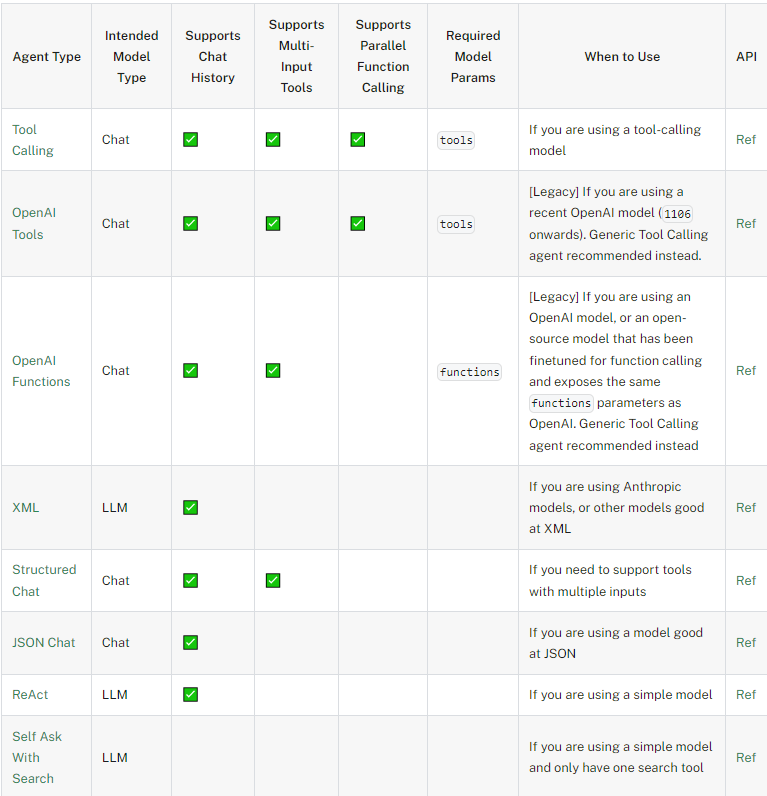



*   Tool Calling : 모델이 하나 이상의 도구를 호출해야 하는 시기를 감지하고 해당 고루에 전달되어야 하는 입력으로 응답하게 한다.
*   OpenAI Tools : 하나 이상의 함수가 호출되어야 하는 시기를 감지하고 함수에 전달되어야 하는 입력에 응답하게 한다. (원래 단일 함수를 호출하는 기능을 함수, 하나 이상의 기능을 호출하는 기능을 도구로 명명했지만, 현재는 도구로 통일)
*   OpenAI Functions : 현재 사용하지 않음
*   XML Agents : 특정 언어 모델은 XML 추론/작성 능력이 뛰어나서, 프롬프트할 때 XML을 사용하는 에이전트를 사용한다.
*   JSON Chat : 해당 에이전트는 JSON을 사용하여 출력 형식을 지정하며 채팅 모델 지원한다.
*   Structured Chat : 다중 입력 도구를 사용하여 구조화된 채팅 에이전트를 구성한다.
*   ReAct : 에이전트를 사용하여 ReAct 논리를 구현한다. (ReAct : 언어 모델에서는 추론과 실행을 분리되어 있는데, 해당 기본 기능을 결합할때의 효과)
*   Self Ask With Search : 검색 에이전트를 사용하여 스스로 질문을 보여준다.




## Agents를 만드는 방법

### 사용자 정의 에이전트
##### OpenAI 도구 호출을 통해서 에이전트를 생성하는데, 이는 일반적으로 에이전트를 생성하는 가장 안정적인 방법이다.
##### 대화를 활성화할려면 메모리를 필요하기 때문에 메모리를 추가해야한다.

In [ ]:
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [ ]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [ ]:
list(agent_executor.stream({"input": "How many letters in the word eudca"}))

### 스트리밍
##### 스트리밍할려는 최종 답변의 토큰뿐만 아니라 에이전트가 수행하는 중간 단계를 다시 스트리밍할 수 있다.
##### Actions <-> Observations --> Final answer : (행동, 관찰) 쌍을 번갈아 출력하고, 에이전트가 목표를 달성한 경우 최종적으로 답변으로 결론을 내린다.

### Running Agent as an Iterator
##### 에이전트를 반복자로 실행하여 필요에 따라 사용자가 참여하여 검사에 도움을 줄 수 있다.

### 구조화된 출력 반환
##### 기본적으로는 대부분의 에이전트는 단일 문자열을 반환한다. 하지만 더 많은 구조를 가진 것을 반환하도록 하는 것이 더 좋을 수도 있다.

### 구문 분석 오류 처리
##### 출력 형식이 올바르게 지정되지 않아서 오류가 발생하면 기본적으로 에이전트 오류가 발생한다.
##### 하지만 handle_parsing_errors를 사용하여 해당 기능을 쉽게 제어할 수 있다.

### 중간 단계 엑세스
##### 에이전트가 수행되는 중에 중간 단계를 반환하고 싶을 때 가능한 작업이다.
##### 이는 (행동, 관찰) 튜플 목록인 반환 값에 추가 키 형태로 제공된다.

### 최대 반복 횟수 제한
##### 특정 단계 수를 제한하는 방법이다. 해당 방법은 문제가 발생하지 않고 너무 많은 단계를 거치지 않도록 방지하는데 유용하다.

### 에이전트 시간 초과
##### 일정 시간이 지난 후 에이전트 실행자를 제한하는 방법이다.
##### 해당 방법은 장기 실행 에이전트를 방지하는데 유용하다.